In [385]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt

In [386]:
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')
print(ratings_df.shape)
print(ratings_df.head())


(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


Remove timestamp column

In [387]:
ratings_df = ratings_df.drop('timestamp', axis=1)
print(ratings_df.head())

   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


In [388]:
Counter(ratings_df['rating'])

Counter({4.0: 26818,
         5.0: 13211,
         3.0: 20047,
         2.0: 7551,
         1.0: 2811,
         4.5: 8551,
         3.5: 13136,
         2.5: 5550,
         0.5: 1370,
         1.5: 1791})

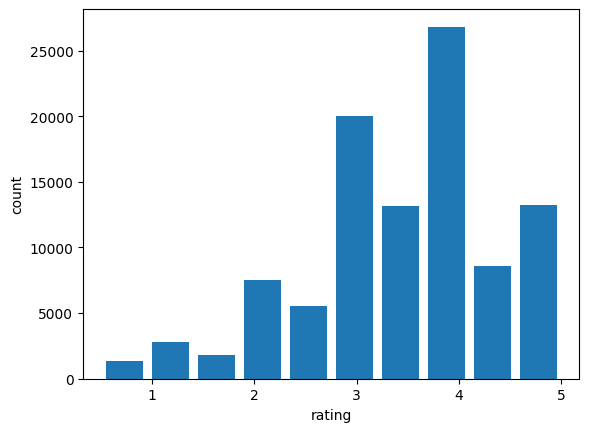

In [389]:
# plot ratings distribution
plt.hist(ratings_df['rating'], bins=10, rwidth=0.8)
plt.xlabel('rating')
plt.ylabel('count')
plt.show()

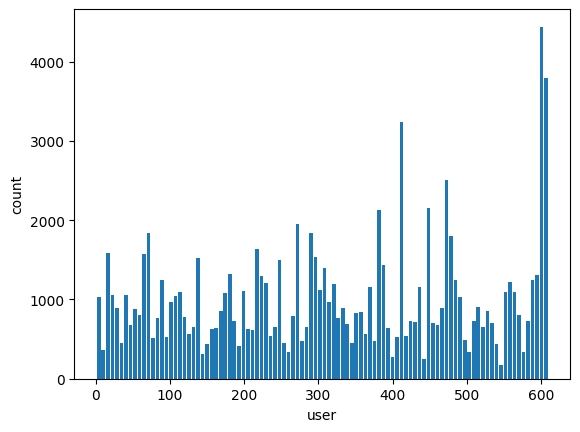

In [390]:
# plot user ratings distribution
plt.hist(ratings_df['userId'], bins=100, rwidth=0.8)
plt.xlabel('user')
plt.ylabel('count')
plt.show()

Train-Validation Split

In [391]:
train_df, valid_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

#reset index
train_df = train_df.reset_index(drop=True)[['userId', 'movieId', 'rating']]
valid_df = valid_df.reset_index(drop=True)[['userId', 'movieId', 'rating']]


In [392]:
class MovieRecommender(torch.nn.Module):
    def __init__(self, n_users, n_movies, n_factors=50):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.movie_factors = torch.nn.Embedding(n_movies, n_factors)
        self.user_bias = torch.nn.Embedding(n_users, 1)
        self.movie_bias = torch.nn.Embedding(n_movies, 1)
        self.global_bias = torch.nn.Parameter(torch.tensor([0.0]))
        
        
    def forward(self, user, movie):
        user_emb = self.user_factors(user)
        movie_emb = self.movie_factors(movie)
        user_bias = self.user_bias(user)
        movie_bias = self.movie_bias(movie)
        # print(user_emb.shape, movie_emb.shape, user_bias.shape, movie_bias.shape)
        return (user_emb * movie_emb).sum(dim=1) + user_bias.squeeze() + movie_bias.squeeze() + self.global_bias
    

In [393]:
def encode_column(column):
    keys = column.unique()
    keys_to_idx = {key: idx for idx, key in enumerate(keys)}
    return keys_to_idx, np.array([keys_to_idx[key] for key in column])

def encode_df(df):
    df = df.copy()
    keys_to_idx = {}
    for column in df.columns:
        if(column == 'rating'):
            continue
        keys_to_idx[column], df[column] = encode_column(df[column])
    return keys_to_idx, df

In [394]:
# encode user and movie ids
keys_to_idx, train_df = encode_df(train_df)
_, valid_df = encode_df(valid_df)


epoch: 0, loss: 56.587890625
epoch: 10, loss: 46.7013053894043
epoch: 20, loss: 42.082237243652344
epoch: 30, loss: 38.008583068847656
epoch: 40, loss: 34.428314208984375
epoch: 50, loss: 31.26825523376465
epoch: 60, loss: 28.467355728149414
epoch: 70, loss: 25.975385665893555
epoch: 80, loss: 23.75068473815918
epoch: 90, loss: 21.7584228515625
epoch: 100, loss: 19.969295501708984
epoch: 110, loss: 18.358442306518555
epoch: 120, loss: 16.90468978881836
epoch: 130, loss: 15.589865684509277
epoch: 140, loss: 14.398313522338867
epoch: 150, loss: 13.31647777557373
epoch: 160, loss: 12.33257007598877
epoch: 170, loss: 11.436301231384277
epoch: 180, loss: 10.618647575378418
epoch: 190, loss: 9.871681213378906
epoch: 200, loss: 9.188405990600586
epoch: 210, loss: 8.562629699707031
epoch: 220, loss: 7.988859176635742
epoch: 230, loss: 7.462204933166504
epoch: 240, loss: 6.9783124923706055
epoch: 250, loss: 6.533285140991211
epoch: 260, loss: 6.123631000518799
epoch: 270, loss: 5.74621772766113

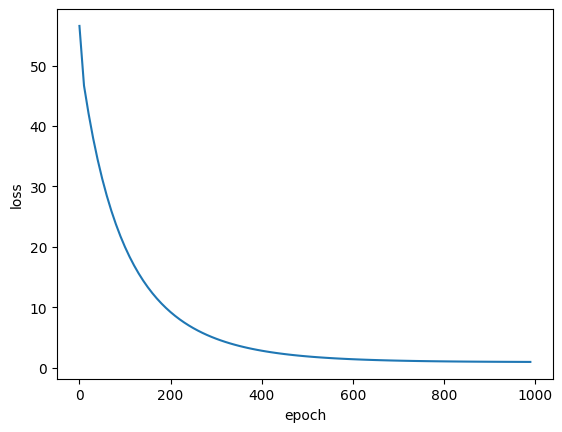

In [395]:
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
model = MovieRecommender(n_users, n_movies, n_factors=50)

# define loss function
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, yhat, y):
        return (self.mse(yhat, y))

loss_func = RMSELoss()

# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, weight_decay=0.01 )

epochs = 1000
batch_size = 1024


def train(model, loss_func, optimizer, epochs, batch_size):
    epoch_list = []
    train_loss_list = []
    for epoch in range(epochs):
        for i in range(0, train_df.shape[0], batch_size):
            batch = train_df.iloc[i:i+batch_size]
            user = torch.tensor(batch['userId'].values, dtype=torch.long)
            # print(user.shape)
            movie = torch.tensor(batch['movieId'].values, dtype=torch.long)
            # print(movie.shape)
            rating = torch.tensor(batch['rating'].values, dtype=torch.float)
            yhat = model(user, movie)
            loss = loss_func(yhat, rating)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print('epoch: {}, loss: {}'.format(epoch, loss.item()))
            epoch_list.append(epoch)
            train_loss_list.append(loss.item())
    return epoch_list, train_loss_list

epoch_list, train_loss_list =train(model, loss_func, optimizer, epochs, batch_size)

# plot loss
plt.plot(epoch_list, train_loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

def predict(model, user, movie):
    user = torch.tensor([user], dtype=torch.long)
    movie = torch.tensor([movie], dtype=torch.long)
    return model(user, movie).item()



In [396]:
# validation error
valid_df_user = torch.tensor(valid_df['userId'].values, dtype=torch.long)
valid_df_movie = torch.tensor(valid_df['movieId'].values, dtype=torch.long)

yhat = model(valid_df_user, valid_df_movie)
y = torch.tensor(valid_df['rating'].values, dtype=torch.float)

loss = loss_func(yhat, y)
print('validation loss: {}'.format(loss.item()))

# convert y and yhat to list
y = y.tolist()
yhat = yhat.tolist()

# zip y and yhat
y_yhat = list(zip(y, yhat))
for prediction in y_yhat:
    print('actual: {}, predicted: {}'.format(prediction[0], prediction[1]))


validation loss: 1.2309253215789795
actual: 4.5, predicted: 3.748116970062256
actual: 3.0, predicted: 3.8874781131744385
actual: 3.0, predicted: 3.4236392974853516
actual: 4.0, predicted: 3.6731812953948975
actual: 4.0, predicted: 3.696296453475952
actual: 4.0, predicted: 2.893667459487915
actual: 3.5, predicted: 3.4580492973327637
actual: 4.5, predicted: 3.9422760009765625
actual: 0.5, predicted: 3.395583152770996
actual: 3.5, predicted: 3.6951770782470703
actual: 4.5, predicted: 3.8941121101379395
actual: 4.0, predicted: 3.0818569660186768
actual: 5.0, predicted: 3.467909812927246
actual: 5.0, predicted: 3.006714344024658
actual: 4.0, predicted: 3.291017770767212
actual: 3.5, predicted: 3.376984119415283
actual: 4.5, predicted: 3.239628314971924
actual: 3.0, predicted: 3.540994644165039
actual: 3.5, predicted: 3.681868314743042
actual: 2.5, predicted: 4.005478858947754
actual: 3.5, predicted: 4.5255818367004395
actual: 2.0, predicted: 3.6843550205230713
actual: 5.0, predicted: 3.2264

### Content Based Filtering

In [397]:
userNUM=7 #change this to see different user's top 20 movies
movies_df = pd.read_csv('movies.csv')
ratings_cb_df=pd.read_csv('ratings.csv')
ratings_cb_df=ratings_cb_df.drop('timestamp',axis=1)
# print(ratings_cb_df.head())
# print(movies_df.head())

In [398]:
# unique genres
genres = set()
for genre in movies_df['genres'].str.split('|'):
    genres.update(genre)
genres = list(genres)
genres.remove('(no genres listed)')
genres=sorted(genres)
genres.append('no genres listed')
print(genres)

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'no genres listed']


In [399]:
# create genre columns
movies_genres_df = movies_df.copy()
for genre in genres:
    movies_genres_df[genre] = movies_genres_df['genres'].str.contains(genre).astype(int)
print(movies_genres_df.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  Action  Adventure  Animation  \
0  Adventure|Animation|Children|Comedy|Fantasy       0          1          1   
1                   Adventure|Children|Fantasy       0          1          0   
2                               Comedy|Romance       0          0          0   
3                         Comedy|Drama|Romance       0          0          0   
4                                       Comedy       0          0          0   

   Children  Comedy  Crime  Documentary  ...  Horror  IMAX  Musical  Mystery  \
0         1       1      0            0  ...       0     0        0        0   
1         1       0      0            0  ...       0     0

In [400]:
user1_ratings=ratings_cb_df[ratings_cb_df['userId']==userNUM]
user1_ratings=user1_ratings.merge(movies_df,on='movieId')
user1_ratings=user1_ratings.drop(['genres','userId'],axis=1)
print(user1_ratings.head())


   movieId  rating                              title
0        1     4.5                   Toy Story (1995)
1       50     4.5         Usual Suspects, The (1995)
2       58     3.0  Postman, The (Postino, Il) (1994)
3      150     4.5                   Apollo 13 (1995)
4      165     4.0  Die Hard: With a Vengeance (1995)


In [401]:
user1_genres=movies_genres_df[movies_genres_df['movieId'].isin(user1_ratings['movieId'])]
user1_genres=user1_genres.drop(['movieId','title','genres'],axis=1)
# print(user1_genres)

In [402]:
user1_genres.reset_index(drop=True,inplace=True)
print(user1_genres.shape)
print(user1_ratings.shape)
# print(user1_ratings.rating)
user1_profile=user1_genres.T.dot(user1_ratings.rating)
print(user1_profile)

(152, 20)
(152, 3)
Action              208.5
Adventure           179.0
Animation            47.5
Children             48.0
Comedy              155.0
Crime                86.0
Documentary           0.0
Drama               178.5
Fantasy              70.5
Film-Noir             6.5
Horror               20.0
IMAX                 27.0
Musical              33.0
Mystery              44.5
Romance              79.5
Sci-Fi              132.5
Thriller            147.5
War                  39.5
Western               1.5
no genres listed      0.0
dtype: float64


In [403]:
# genres table for all movies
movies_genres_df=movies_genres_df.drop(['movieId','title','genres'],axis=1)

In [404]:
recommendation_table_df=((movies_genres_df*user1_profile).sum(axis=1))/(user1_profile.sum())
recommendation_table_df=recommendation_table_df.sort_values(ascending=False)
top_20=recommendation_table_df.index[:20].tolist()
# print(recommendation_table_df.head(5))
print('*************************************************************** content based recommendation ************************************************************\n')
print(movies_df.loc[top_20])

*************************************************************** content based recommendation ************************************************************

      movieId                                              title  \
7441    81132                                      Rubber (2010)   
7170    71999          Aelita: The Queen of Mars (Aelita) (1924)   
3608     4956                              Stunt Man, The (1980)   
8597   117646              Dragonheart 2: A New Beginning (2000)   
4631     6902                               Interstate 60 (2002)   
3460     4719                               Osmosis Jones (2001)   
9394   164226                                Maximum Ride (2016)   
400       459                                Getaway, The (1994)   
6570    55116                          Hunting Party, The (2007)   
5774    31367                                  Chase, The (1994)   
5556    26701  Patlabor: The Movie (Kidô keisatsu patorebâ: T...   
7767    91500                